In [2]:
import torch
from utils.architectures.cxmodels import complex_fcos_resnet_fpn
from utils.architectures.rlmodels import real_fcos_resnet_fpn
from utils.dataset import create_detection_dataset
from utils.metric import calculate_iou, calculate_p_r_f1
from torchvision.ops import boxes as box_ops

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


cuda


In [17]:
real = True
if real:
        checkpoint_path = '/home/wittej/cvnn4sar/SARFish/CVNN/pipeline/utils/pretrained_models_6/detection/SARFish_data/d_fold/fold_2/amp_only/resnet18/128_16/1/without_fb_checkpoint.pth'
        dataset_file = '/mnt/sasa028/cvnn4sar/SARFish/SARFish_data/detection_dataset/SLC/d_fold/128_16/1/fold_2.json'
        
        model = real_fcos_resnet_fpn('resnet18', in_channels=2, num_classes=4,
                             image_mean=[0,0], image_std=[1,1], 
                                frozen_backbone=None, nms_tresh=0.5)
        test_data = create_detection_dataset(dataset_file, 'amp_only', drop_low=True, drop_empty=True, partition='test')
        test_sampler = torch.utils.data.RandomSampler(test_data)
        test_data_loader = torch.utils.data.DataLoader(
        test_data, batch_size = 1, sampler = test_sampler, num_workers = 0
        )
        print(len(test_data))
        print(sum(p.numel() for p in model.parameters() if p.requires_grad))
        #print(model)
else:
        checkpoint_path = '/home/wittej/cvnn4sar/SARFish/CVNN/pipeline/utils/pretrained_models_6/detection/SNAP_data/d_fold/fold_1/complex/resnet18/128_16/4/without_fb_checkpoint.pth'
        dataset_file = '/mnt/sasa028/cvnn4sar/SARFish/SNAP_data/detection_dataset/SLC/d_fold/128_16/4/fold_1.json'

        model = complex_fcos_resnet_fpn('resnet18', in_channels=2, num_classes=4,
                                  frozen_backbone=None, nms_tresh=0.5)
        test_data = create_detection_dataset(dataset_file, 'complex', drop_low=True, drop_empty=True, partition='test')
        test_sampler = torch.utils.data.RandomSampler(test_data)
        test_data_loader = torch.utils.data.DataLoader(
        test_data, batch_size = 1, sampler = test_sampler, num_workers = 0
        )
        print(2 * sum(p.numel() for p in model.parameters() if p.requires_grad))
        print(model)

1393
19100937


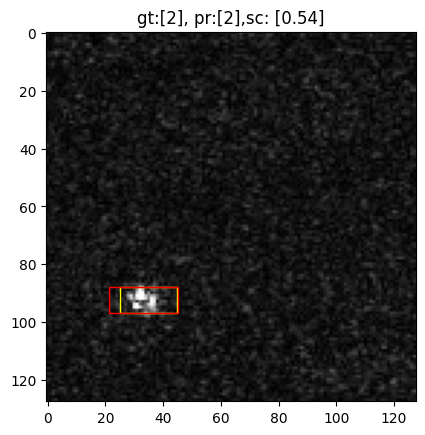

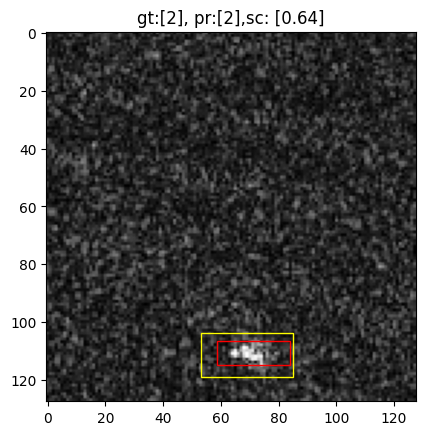

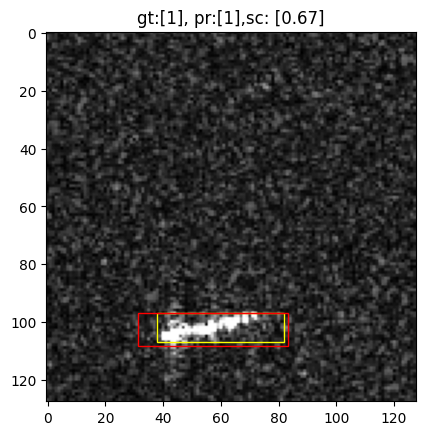

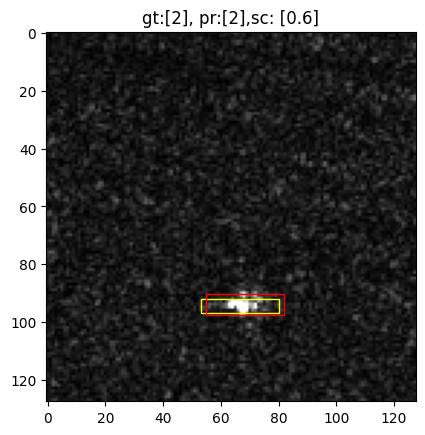

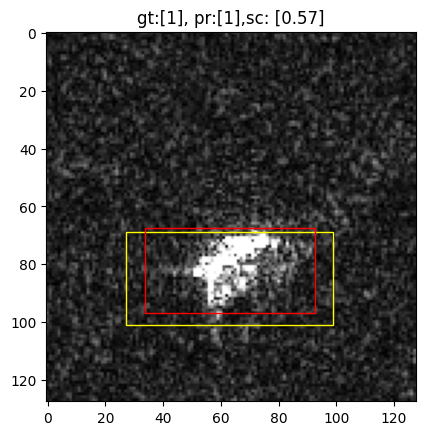

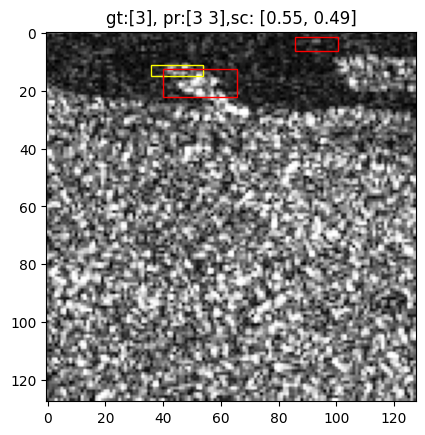

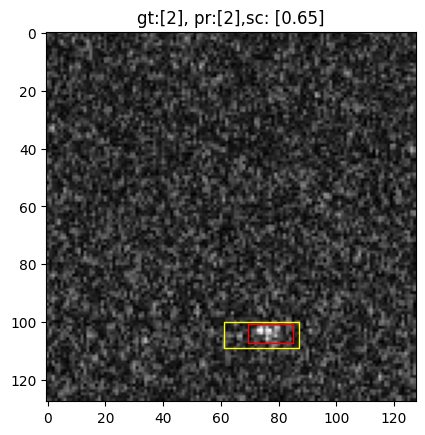

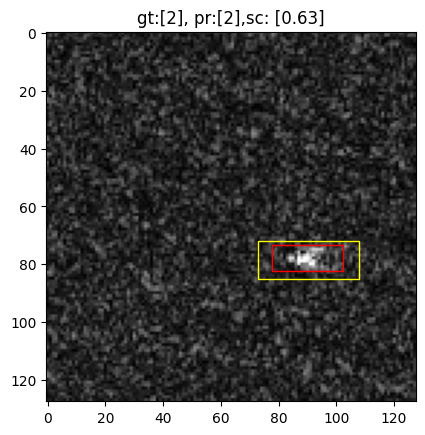

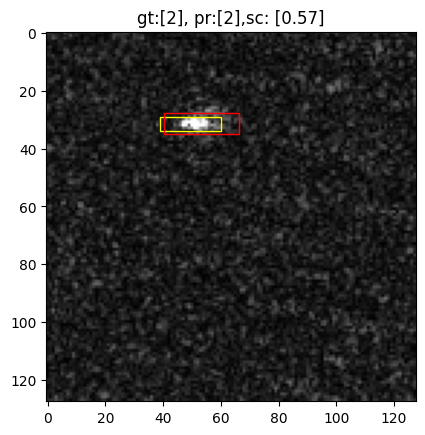

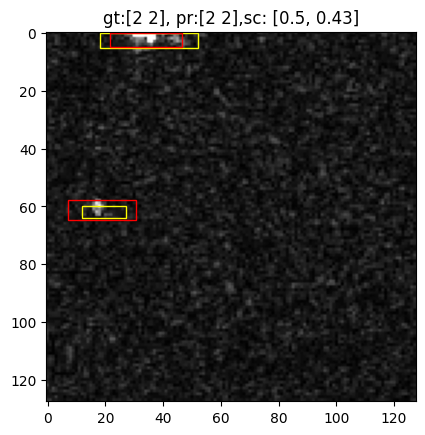

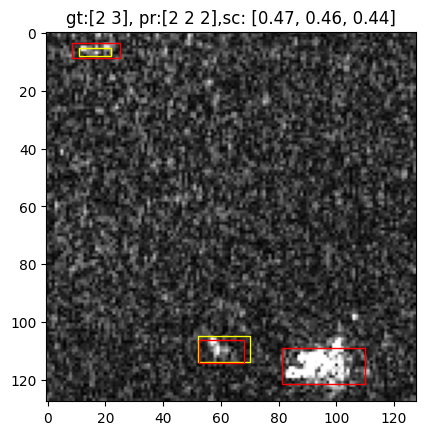

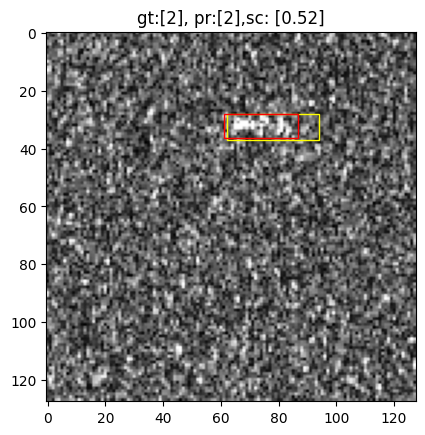

14 2 0
precision: 0.875
recall: 1.0
f1: 0.933
[[ 0.  0.  0.  0.]
 [ 0.  2.  0.  0.]
 [ 0.  0. 10.  1.]
 [ 0.  0.  0.  1.]]


In [16]:
model.load_state_dict(torch.load(str(checkpoint_path), map_location = device))
model.to(device)
model.eval()
total_true_positives = 0
total_false_positives = 0
total_false_negatives = 0
total_confusion = np.zeros((4,4))

with torch.no_grad():
    for test_id, (test_image, test_targets) in enumerate(test_data_loader):

        prediction = model(test_image)
        
        predicted_boxes = prediction[0]['boxes']
        scores = prediction[0]['scores']
        predicted_classes= prediction[0]['labels']

        #perform non_class based nms
        keep = box_ops.nms(predicted_boxes, scores, 0.1)
        predicted_boxes = predicted_boxes[keep]
        predicted_classes = predicted_classes[keep]
        scores = scores[keep]

        predicted_boxes = predicted_boxes.cpu().detach().numpy()
        scores = scores.cpu().detach().numpy()
        predicted_classes = predicted_classes.cpu().detach().numpy()
        
        groundtruth_boxes = test_targets['boxes'].squeeze(0).cpu().detach().numpy()
        groundtruth_classes = test_targets['labels'].squeeze(0).cpu().detach().numpy()

        num_detect = len(predicted_boxes) 
        
        if num_detect == 0:
            total_false_negatives += len(groundtruth_boxes)
            continue
        
        #Only output scores larger than threshold
        is_good_score = scores > 0.39
        predicted_boxes = predicted_boxes[is_good_score, :]
        predicted_classes = predicted_classes[is_good_score]
        scores = scores[is_good_score]
        image_true_positives = 0
        
        rects_gt = [Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1], facecolor='none', edgecolor='yellow') for gt_box in groundtruth_boxes]
        rects_pr = [Rectangle((pr_box[0], pr_box[1]), pr_box[2] - pr_box[0], pr_box[3] - pr_box[1], facecolor='none', edgecolor='red') for pr_box in predicted_boxes]

        matched_gt = set()
        matched_pred = set()

        for gt_id, gt_box in enumerate(groundtruth_boxes):
            max_iou_for_gt = 0
            best_pred_id = None
            for pr_id, pr_box in enumerate(predicted_boxes):
                iou_for_pr_gt = calculate_iou(pr_box, gt_box)
                if iou_for_pr_gt > max_iou_for_gt:
                    max_iou_for_gt = iou_for_pr_gt
                    best_pred_id = pr_id

            if max_iou_for_gt > 0.1 :
                image_true_positives += 1
                matched_gt.add(gt_id)
                matched_pred.add(best_pred_id)
                pred_class = predicted_classes[best_pred_id]
                gt_class = groundtruth_classes[gt_id]
                total_confusion[pred_class, gt_class] += 1
        
        image_false_positives = len(predicted_boxes) - len(matched_pred)
        image_false_negatives = len(groundtruth_boxes) - len(matched_gt)
        
        total_true_positives += image_true_positives
        total_false_positives += image_false_positives
        total_false_negatives += image_false_negatives
    
        fig, ax = plt.subplots()
        ax.imshow((test_image.squeeze().cpu().detach().numpy())[1], cmap='Greys_r')
        [ax.add_patch(rect) for rect in rects_gt]
        [ax.add_patch(rect) for rect in rects_pr]
        ax.set_title(f'gt:{groundtruth_classes}, pr:{predicted_classes},sc: {[round(score, 2) for score in scores]}')
        plt.show()
        if test_id > 10:
            break        

    print(total_true_positives, total_false_positives, total_false_negatives)
    precision, recall, f1_score = calculate_p_r_f1(total_true_positives, total_false_positives, total_false_negatives)
    print(f'precision: {round(precision, 3)}')
    print(f'recall: {round(recall, 3)}')
    print(f'f1: {round(f1_score, 3)}')
    print(total_confusion)